In [2]:
import vector
import tqdm
import awkward as ak

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pathlib import Path

import pandas as pd

import numpy as np

import glob


files = glob.glob('/users/dponman/data/dponman/qcd/*parquet')[:500]

parquet_list = []
arr = ak.concatenate([ak.from_parquet(file) for file in tqdm.tqdm(files)])

100%|██████████| 500/500 [00:26<00:00, 18.85it/s]


In [3]:
charged = (arr.particles.target.cls_id == 1)
neutral = (arr.particles.target.cls_id == 2)
hf_had  = (arr.particles.target.cls_id == 3)
hf_em   = (arr.particles.target.cls_id == 4)
gamma   = (arr.particles.target.cls_id == 5)
e       = (arr.particles.target.cls_id == 6)
mu      = (arr.particles.target.cls_id == 7)

pt_cut = (arr.particles.target.pt > 1)

charged_target = arr.particles.target[charged]
neutral_target = arr.particles.target[neutral]
hfhad_target   = arr.particles.target[hf_had]
hfem_target    = arr.particles.target[hf_em]
gamma_target   = arr.particles.target[gamma]
e_target       = arr.particles.target[e]
mu_target      = arr.particles.target[mu]

charged_pred = arr.particles.pred[charged]
neutral_pred = arr.particles.pred[neutral]
hfhad_pred   = arr.particles.pred[hf_had]
hfem_pred    = arr.particles.pred[hf_em]
gamma_pred   = arr.particles.pred[gamma]
e_pred       = arr.particles.pred[e]
mu_pred      = arr.particles.pred[mu]

particle_types = {
    'Charged_had'   : [charged_target, charged_pred],
    'Neutral_had'   : [neutral_target, neutral_pred],
    'HF_had'    : [hfhad_target, hfhad_pred],
    'HF_em'     : [hfem_target, hfem_pred],
    'Photon'    : [gamma_target, gamma_pred],
    'Electron'  : [e_target, e_pred],
    'Muon'      : [mu_target, mu_pred]
    
}

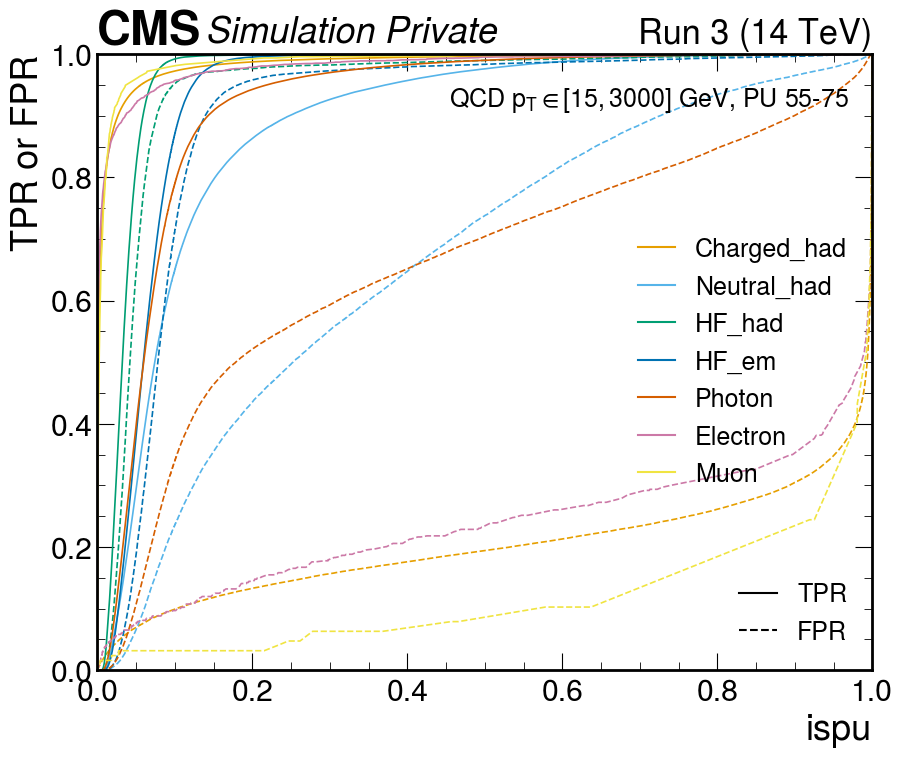

In [4]:
import mplhep as hep
from matplotlib.lines import Line2D

plt.style.use(hep.style.CMS)

colors = {
    'Charged_had':      '#E69F00',
    'Neutral_had':      '#56B4E9',
    'HF_had':       '#009E73',
    'HF_em':         '#0072B2',
    'Photon':      '#D55E00',
    'Electron':    '#CC79A7',
    'Muon':        '#F0E442'
}

plt.figure(figsize=(10, 8))
particle_handles = []
for particle_type in particle_types:
    y_true = ak.flatten(particle_types[particle_type][0].ispu) == 1
    y_scores = ak.flatten(particle_types[particle_type][1].ispu)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    thresholds = 1 - thresholds
    
    color = colors[particle_type]
    plt.plot(thresholds, tpr, color=color, linestyle='-', linewidth=1.2)
    plt.plot(thresholds, fpr, color=color, linestyle='--', linewidth=1.2)
    
    particle_handles.append(Line2D([0], [0], color=color, label=particle_type))


first_legend = plt.legend(handles=particle_handles, loc='best', frameon=False, fontsize='x-small')
plt.gca().add_artist(first_legend)


style_handles = [
    Line2D([0], [0], color='black', linestyle='-', label='TPR'),
    Line2D([0], [0], color='black', linestyle='--', label='FPR')
]
plt.legend(handles=style_handles, loc='lower right', frameon=False, fontsize='x-small')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('ispu', loc='right')
plt.ylabel('TPR or FPR', loc='top')
plt.grid(False)

hep.cms.label("Private", data=False, year='Run 3', com=14)

plt.text(
    0.97, 0.95,
    r"QCD $p_T \in [15, 3000]$ GeV, PU 55-75",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize='x-small'
)


plt.show()

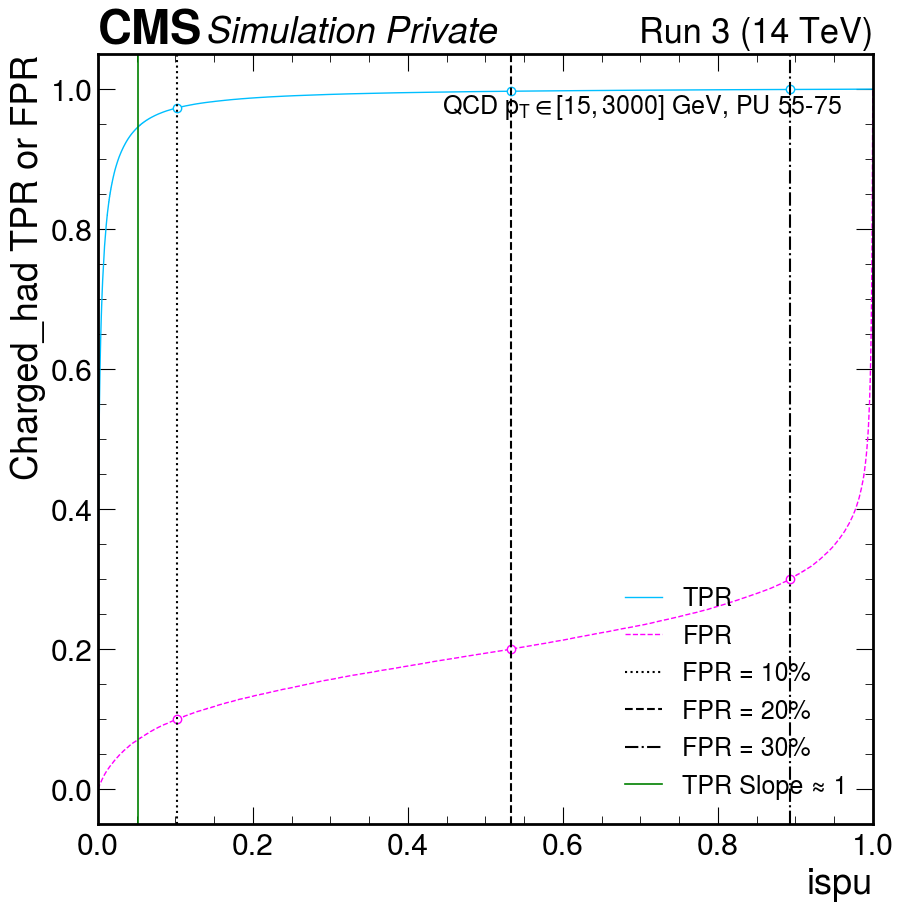

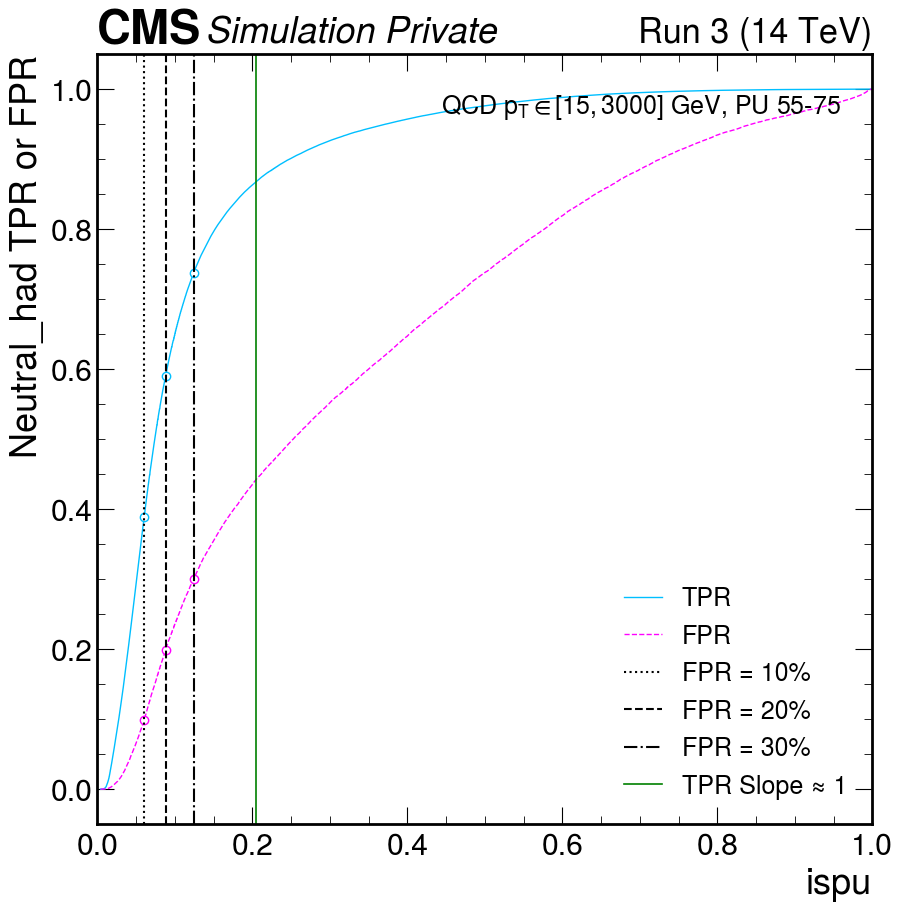

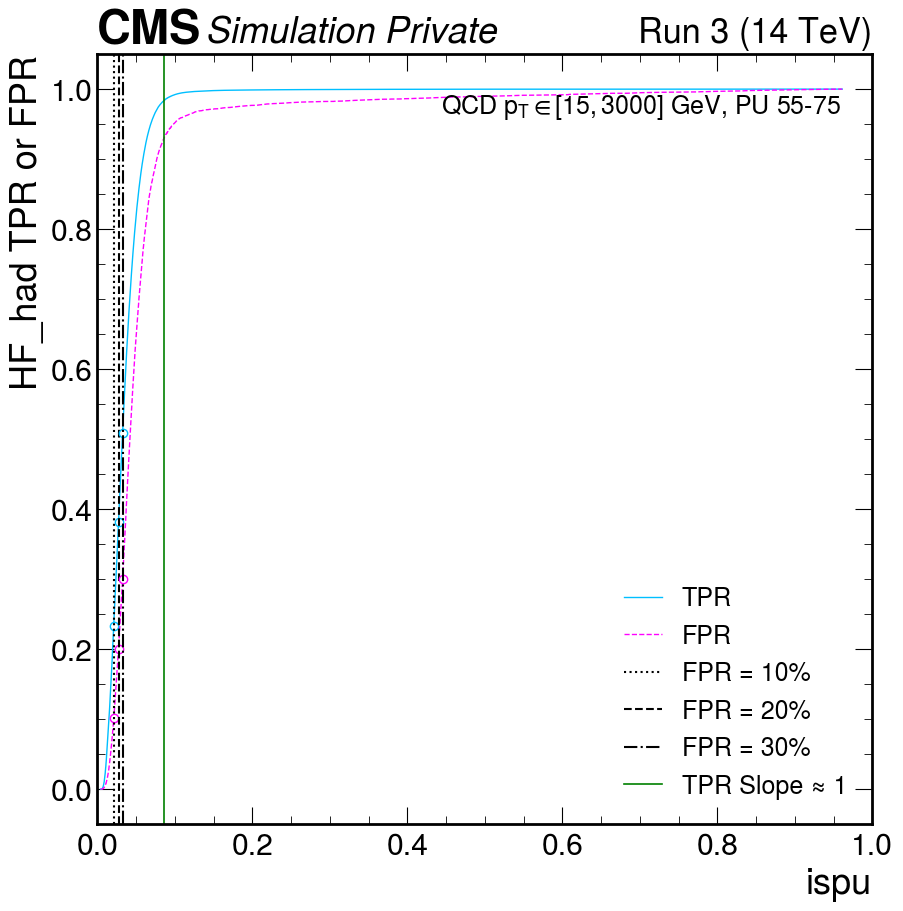

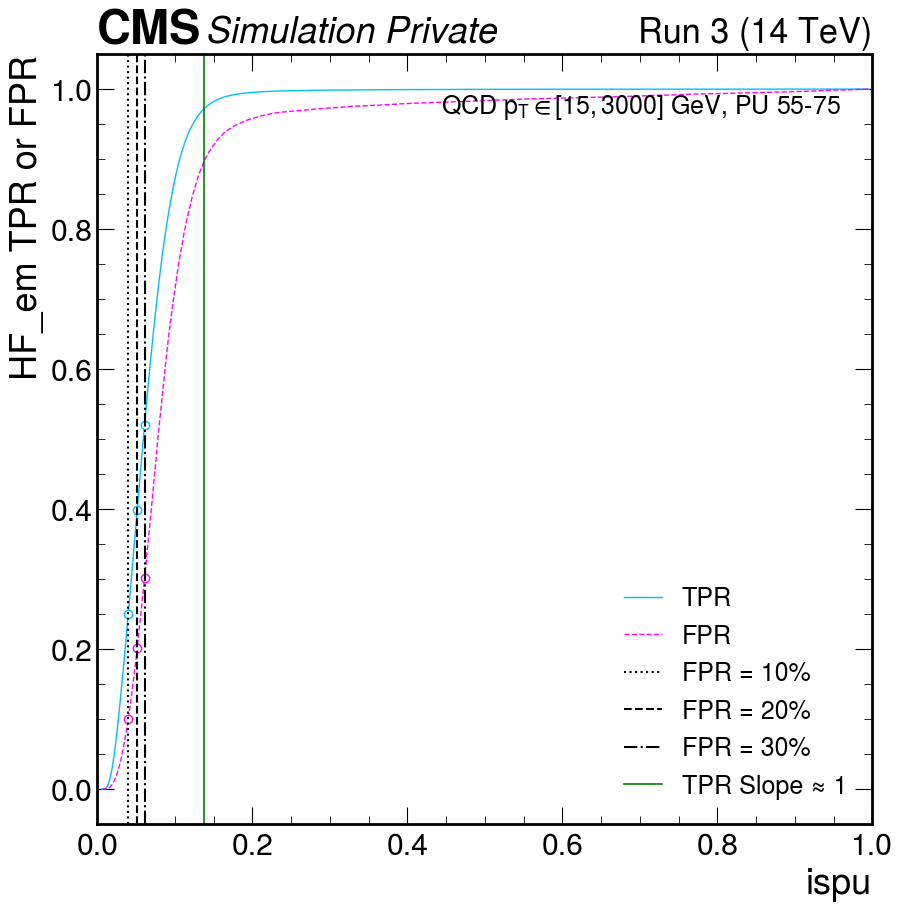

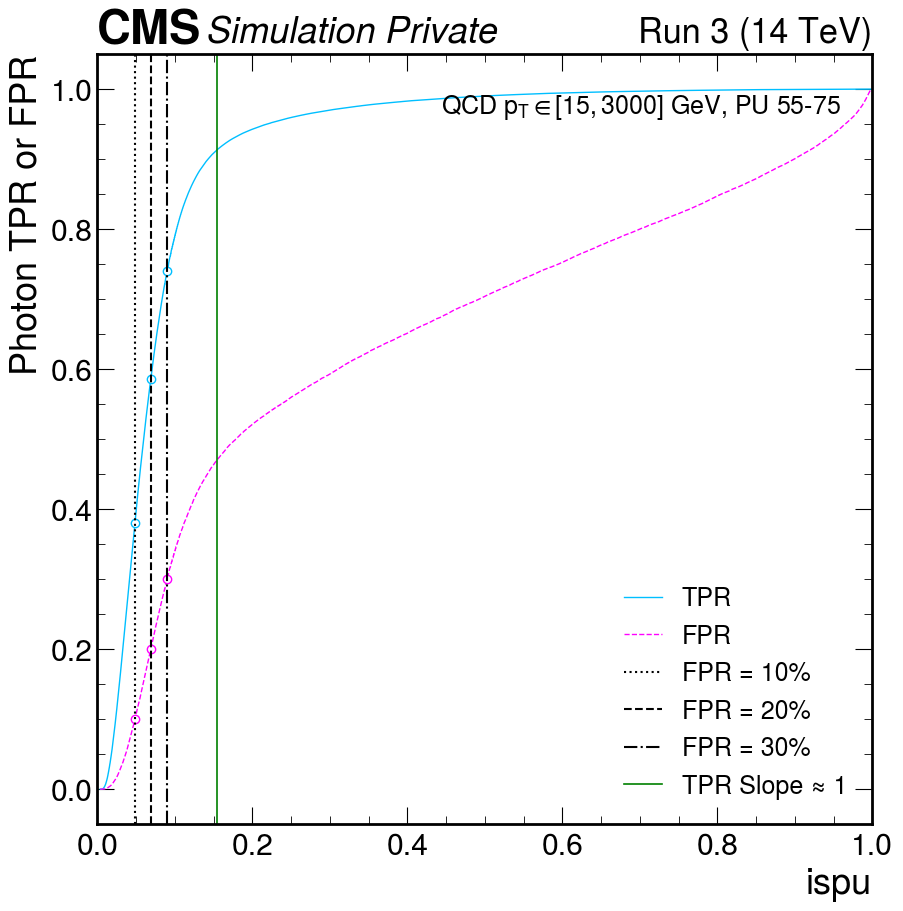

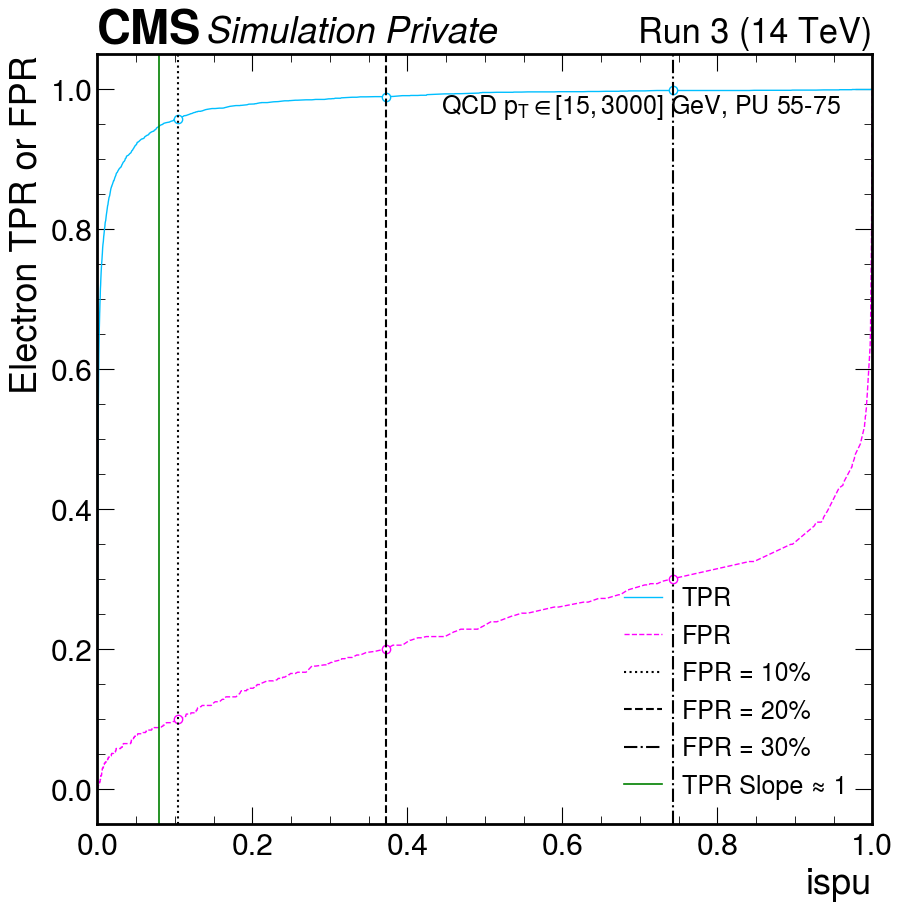

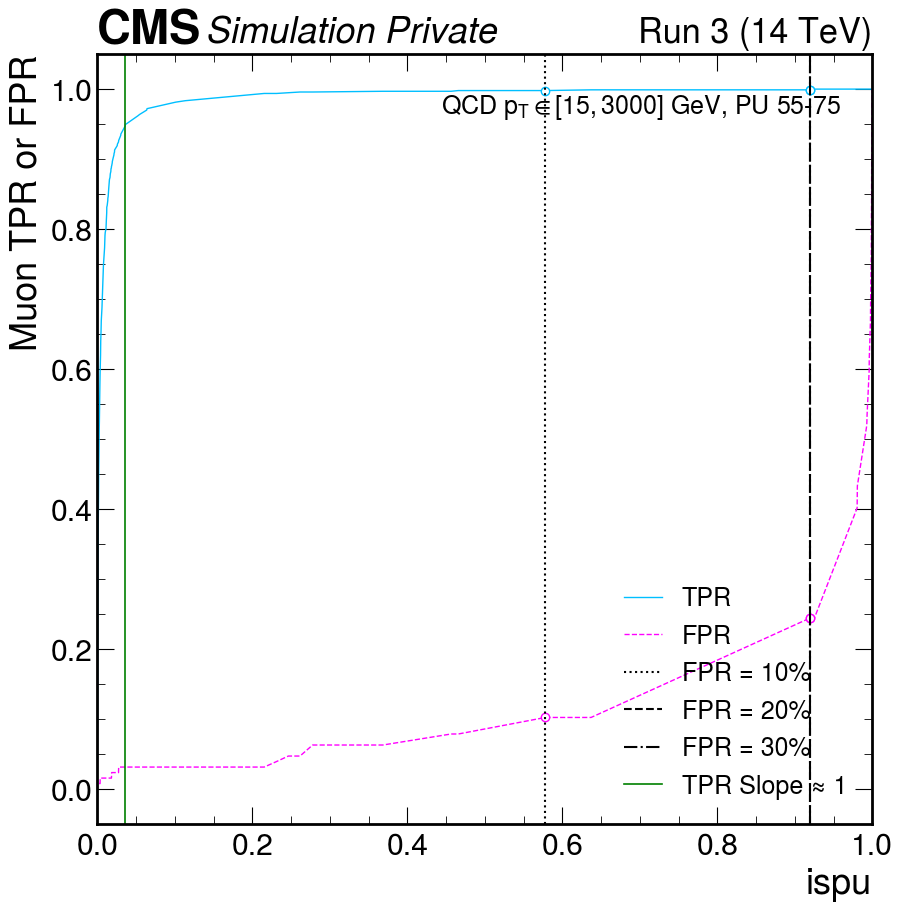

In [5]:
plt.style.use(hep.style.CMS)
tpr_color = 'deepskyblue'
fpr_color = 'fuchsia'

target_fprs = [0.1, 0.2, 0.3]
marker_style = dict(marker='o', markersize=6, markerfacecolor='white', markeredgewidth=1)

line_styles = [':', '--', '-.', '-']

good_thresholds = {
    'Charged_had': None,
    'Neutral_had': None,
    'HF_had': None,
    'HF_em': None,
    'Photon': None,
    'Electron': None,
    'Muon': None
}

for particle_type in particle_types:
    y_true = ak.flatten(particle_types[particle_type][0].ispu) == 1
    y_scores = ak.flatten(particle_types[particle_type][1].ispu)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    thresholds = 1 - thresholds
    
    threshold_markers = {}
    for target_fpr in target_fprs:
        idx = np.argmin(np.abs(fpr - target_fpr))
        threshold_markers[target_fpr] = {
            'threshold': thresholds[idx],
            'tpr': tpr[idx],
            'fpr': fpr[idx]
        }
    
    plt.figure(figsize=(10, 10))
    plt.plot(thresholds, tpr, color=tpr_color, linestyle='-', linewidth=1, label='TPR')
    plt.plot(thresholds, fpr, color=fpr_color, linestyle='--', linewidth=1, label='FPR')
    
    for i, (target_fpr, vals) in enumerate(threshold_markers.items()):
        thresh = vals['threshold']
        tpr_val = vals['tpr']
        fpr_val = vals['fpr']
        linestyle = line_styles[i % len(line_styles)]
        
        plt.plot(thresh, tpr_val, color=tpr_color, **marker_style)
        plt.plot(thresh, fpr_val, color=fpr_color, **marker_style)
        
        plt.axvline(x=thresh, color='black', linestyle=linestyle, linewidth=1.5,
                    label=f'FPR = {target_fpr:.0%}')

    dtpr = np.gradient(tpr)
    dthresh = np.gradient(thresholds)
    slope = dtpr / dthresh

    slope_target = 1
    slope_idx = np.argmin(np.abs(slope - slope_target))
    slope_thresh = thresholds[slope_idx]

    good_thresholds[particle_type] = slope_thresh
    plt.axvline(x=slope_thresh, color='green', linestyle='-', linewidth=1.2, label='TPR Slope ≈ 1')

    
    plt.xlabel('ispu', loc='right')
    plt.ylabel(f'{particle_type} TPR or FPR', loc='top')
    plt.xlim([0, 1])
    plt.ylim([-0.05, 1.05])
    plt.legend(loc = 'lower right', frameon=False, fontsize='x-small')
    plt.grid(False)
    
    hep.cms.label("Private", data=False, year='Run 3', com=14)
    plt.text(
    0.96, 0.95,
    r"QCD $p_T \in [15, 3000]$ GeV, PU 55-75",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize='x-small',
    )

    plt.show()


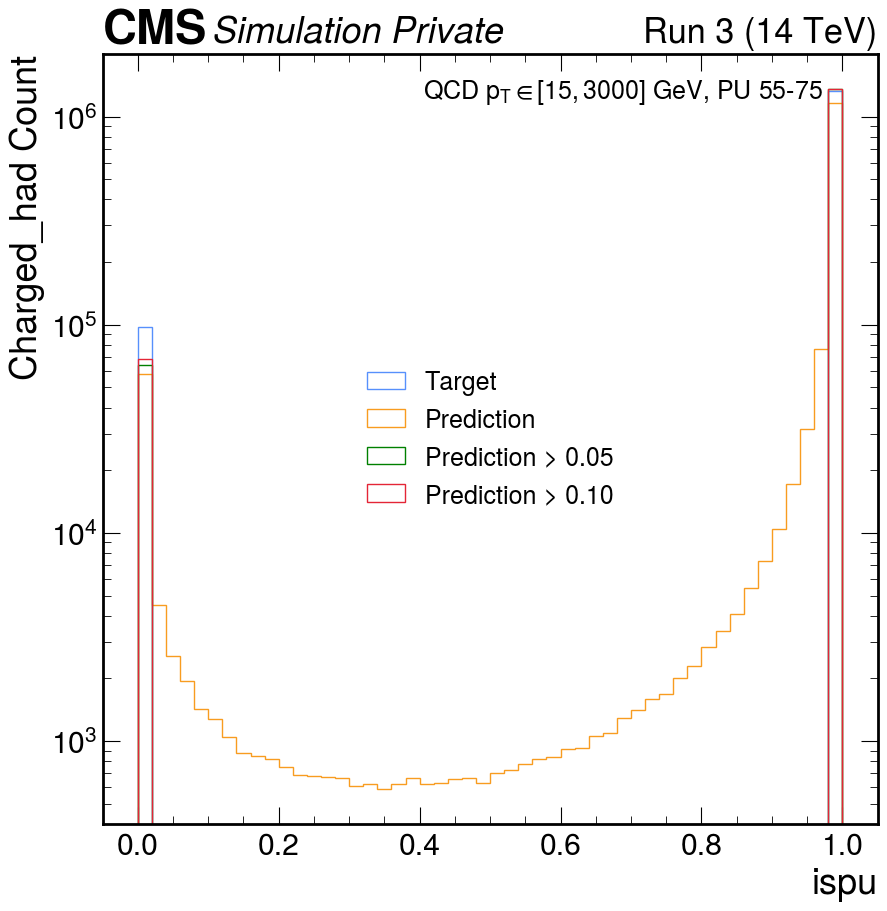

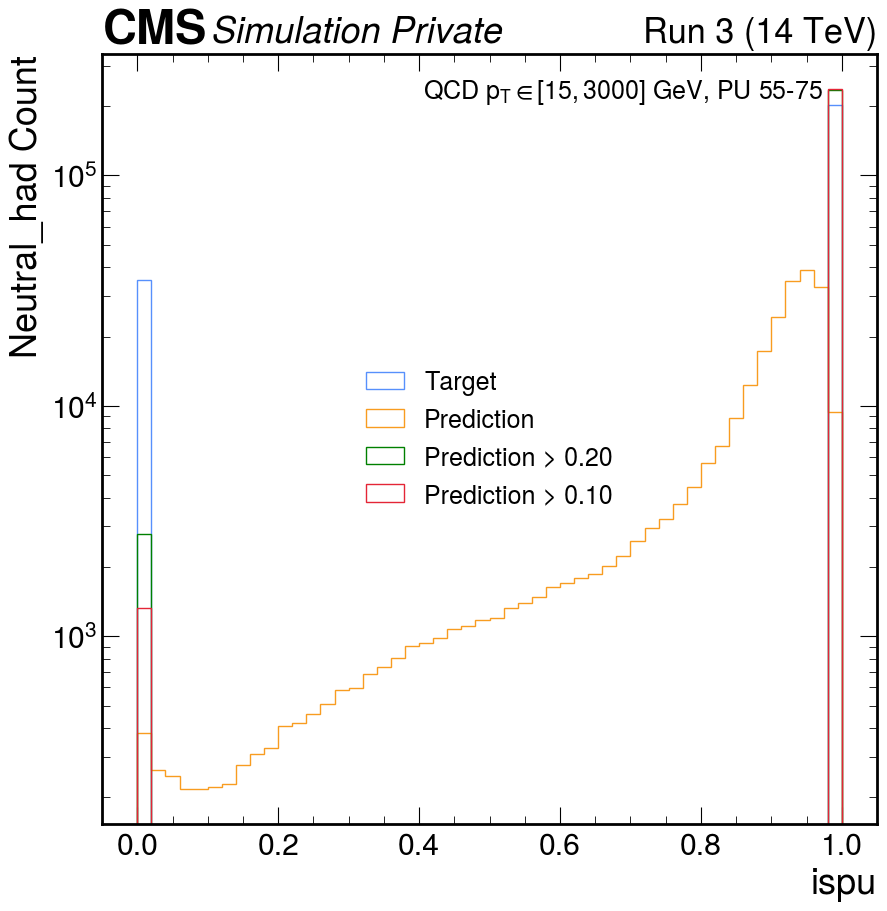

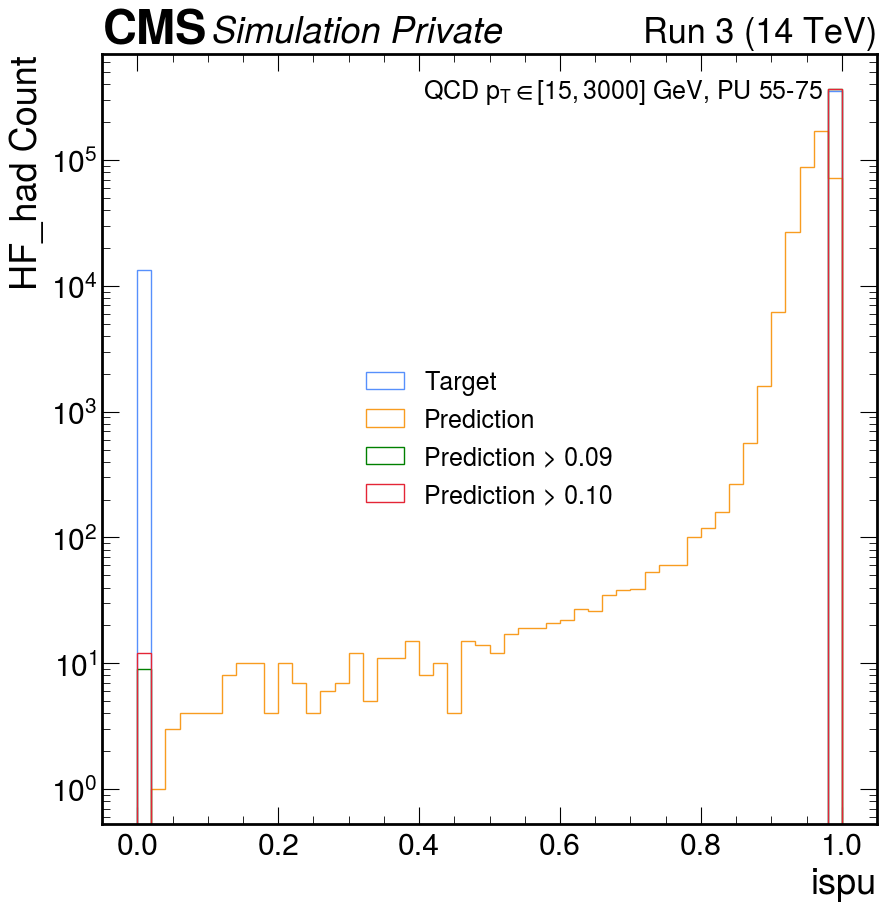

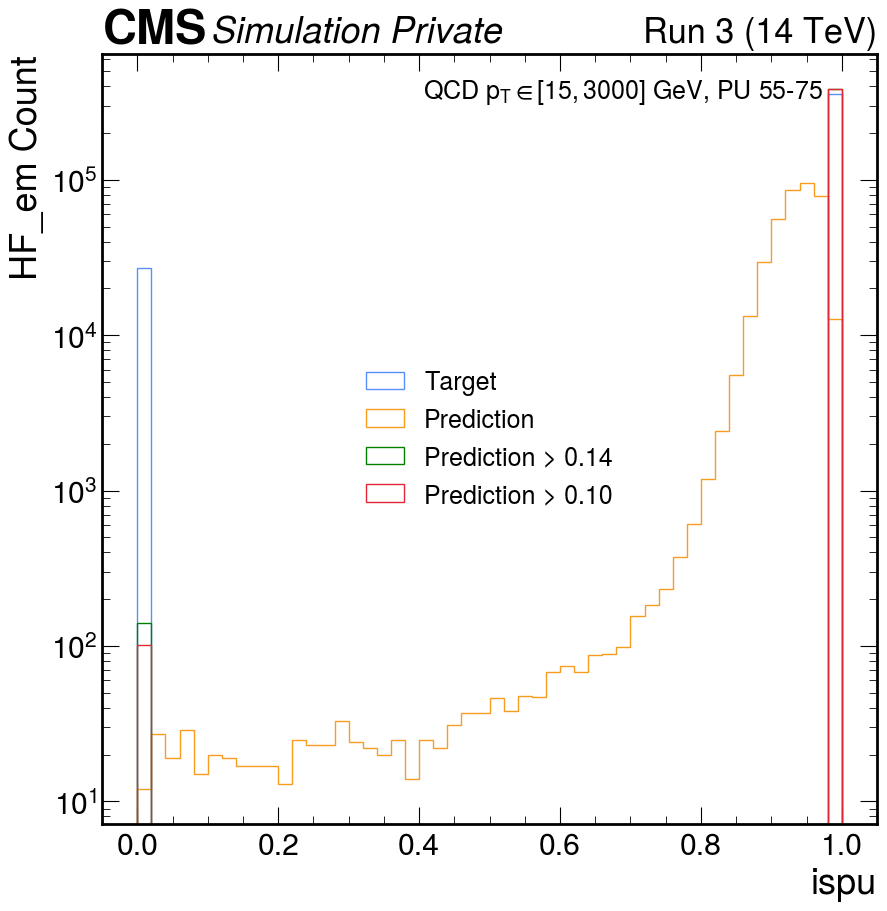

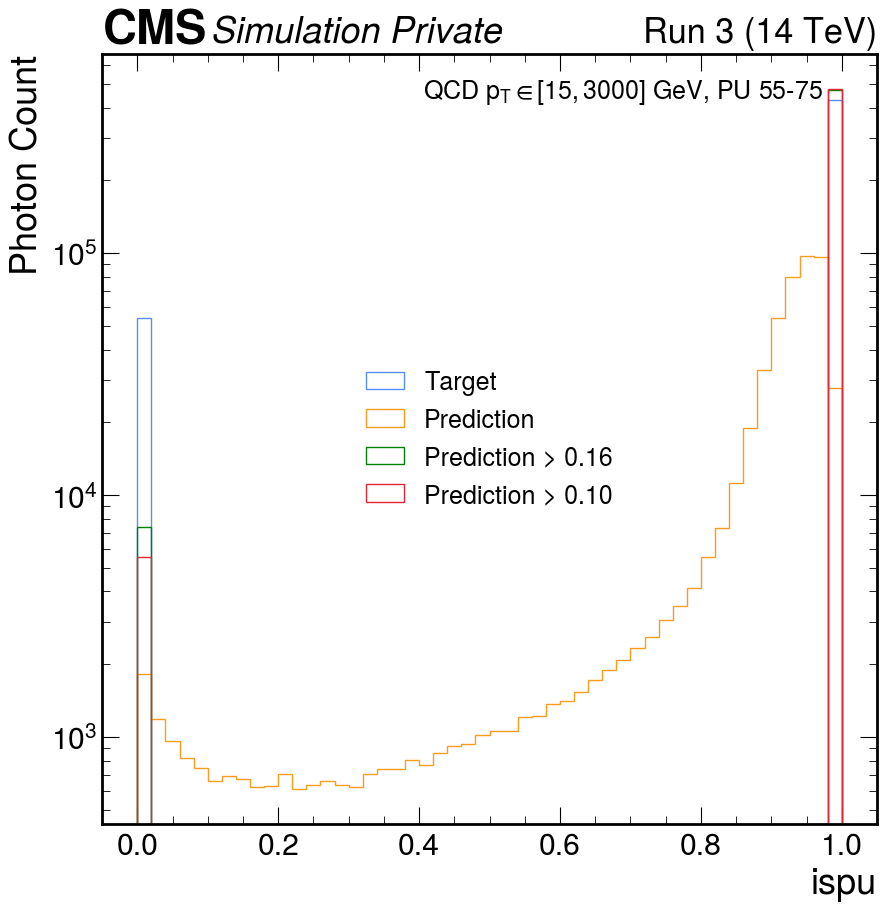

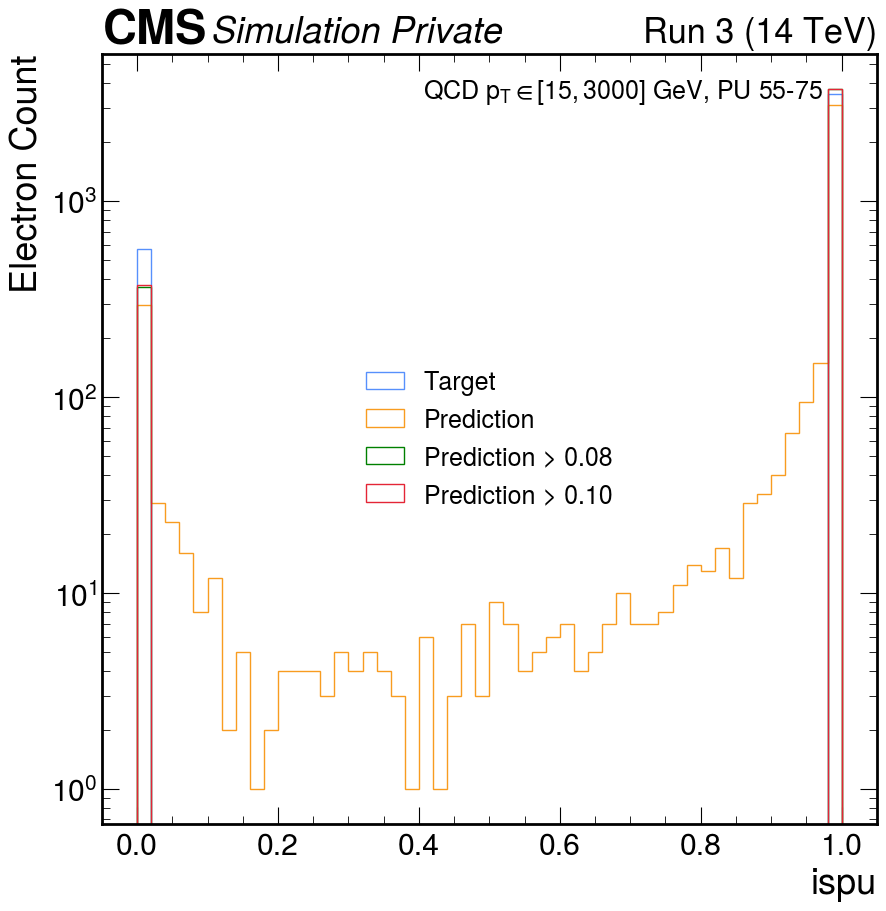

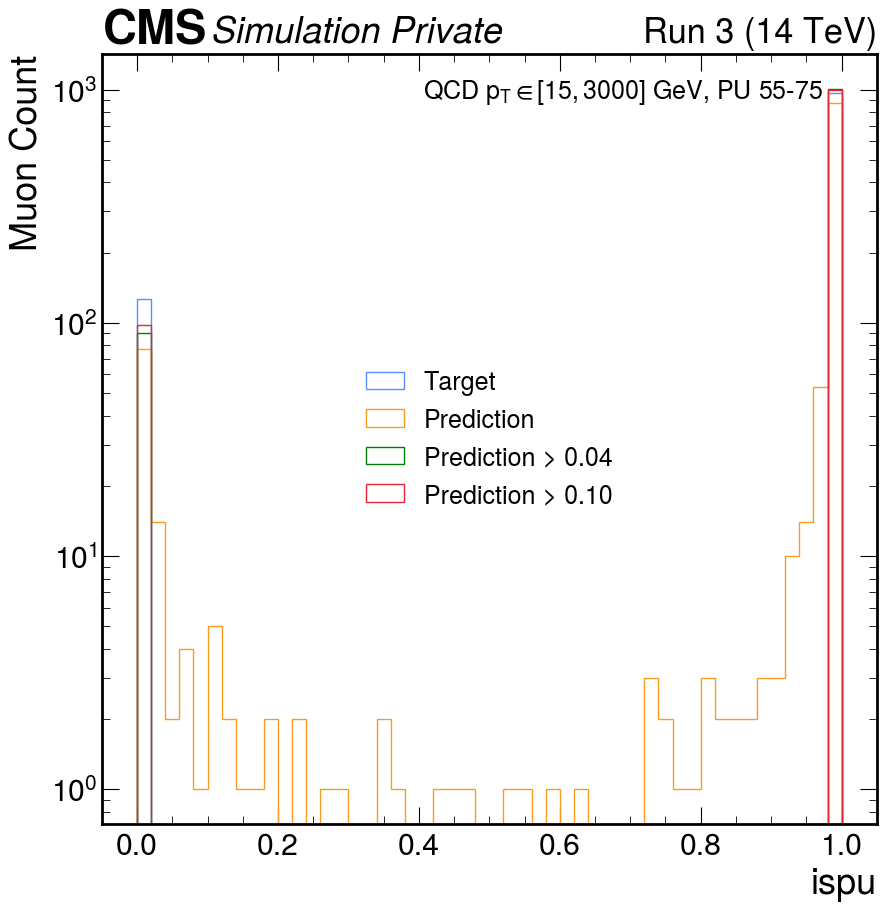

In [6]:
for particle_type in particle_types:
    
    plt.style.use(hep.style.CMS)
    fig = plt.figure()
    ax = plt.gca()    
    
    target_ispu = ak.flatten(particle_types[particle_type][0].ispu)
    pred_ispu = ak.flatten(particle_types[particle_type][1].ispu)
    
    threshold = good_thresholds[particle_type]
    pred_passfail = ak.values_astype(pred_ispu > threshold, int)
    threshold_2 = 0.1
    pred_passfail_2 = ak.values_astype(pred_ispu > threshold_2, int)
    
    plt.hist(target_ispu, bins=50, range=(0, 1), histtype='step', label='Target')
    plt.hist(pred_ispu, bins=50, range=(0, 1), histtype='step', label='Prediction')
    plt.hist(pred_passfail, bins=50, range=(0, 1), histtype='step', label=f'Prediction > {threshold:.2f}', color = 'green')
    plt.hist(pred_passfail_2, bins=50, range=(0, 1), histtype='step', label=f'Prediction > {threshold_2:.2f}')
    
    ax.set_yscale('log')
    ax.set_xlabel("ispu", loc='right')
    ax.set_ylabel(f'{particle_type} Count', loc='top')

    hep.cms.label("Private", data=False, year='Run 3', com=14)
    plt.text(
    0.93, 0.97,
    r"QCD $p_T \in [15, 3000]$ GeV, PU 55-75",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize='x-small',
    )
    
    plt.legend(fontsize='x-small', loc = 'center')
    plt.show()